## Introduction ##
The dataset is available on Kaggle, representing the data collected by a bank to study whether a customer is a good payer or not, distinguishing three classes. This project aims to implement some Machine Learning methods (such as Neural Networks, SVM, and XGBoost) to perform the classification and compare their results.

## Import useful libraries ##

In [3]:
# Standard libraries
import numpy as np 
import pandas as pd 

# Time libraries 
from tqdm import tqdm
from time import time

# Visualization library
import umap.umap_ as UMAP

# Resampling libraries
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler

# Useful library
from collections import Counter

# Scikit-learn libraries for preprocessing and report analysis 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow libraries for Neural Network implementation
import tensorflow as tf
from tensorflow.keras import Sequential, initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Library for NN hyperparameters tuning
import keras_tuner as kt

# XGBoost library
import xgboost as xgb

# Standard plot library
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Loading and Data description ##
Dataset 27 features and 1 target, for a total of $10^6$ instances. 
* <span style="color:blue">**blue**</span> $\rightarrow$ redundant features
* <span style="color:red">**red**</span> $\rightarrow$ features with wrong data type
* <span style="color:green">**green**</span> $\rightarrow$ target
* (#) $\rightarrow$ numerical feature
* (A) $\rightarrow$ categorical feature

1. (<span style="color:blue">**A**</span>) **ID**: Represents a unique identification of an entry;
2. (A) **Customer_ID**: Represents a unique identification of a person;
3. (A) **Month**: Represents the month of the year;
4. (<span style="color:blue">**A**</span>) **Name**: Represents the name of a person;
5. (<span style="color:red">**A**</span>) **Age**: Represents the age of the person;
6. (<span style="color:blue">**A**</span>) **SSN**: Represents the social security number of a person;
7. (A) **Occupation**: Represents the occupation of the person;
8. (<span style="color:red">**A**</span>) **Annual_Income**: Represents the annual income of the person;
9. (#) **Monthly_Inhand_Salary**: Represents the monthly base salary of a person;
10. (#) **Num_Bank_Accounts**: Represents the number of bank accounts a person holds;
11. (#) **Num_Credit_Card**: Represents the number of other credit cards held by a person;
12. (#) **Interest_Rate**: Represents the interest rate on credit card;
13. (<span style="color:red">**A**</span>) **Num_of_Loan**: Represents the number of loans taken from the bank;
14. (A) **Type_of_Loan**: Represents the types of loan taken by a person;
15. (#) **Delay_from_due_date**: Represents the average number of days delayed from the payment date;
16. (<span style="color:red">**A**</span>) **Num_of_Delayed_Payment**: Represents the average number of payments delayed by a person;
17. (#) **Changed_Credit_Limit**: Represents the percentage change in credit card limit;
18. (#) **Num_Credit_Inquiries**: Represents the number of credit card inquiries;
19. (A) **Credit_Mix**: Represents the classification of the mix of credits;
20. (<span style="color:red">**A**</span>) **Outstanding_Debt**: Represents the remaining debt to be paid (in USD);
21. (#) **Credit_Utilization_Ratio**: Represents the utilization ratio of credit card;
22. (<span style="color:red">**A**</span>) **Credit_History_Age**: Represents the age of credit history of the person;
23. (A) **Payment_of_Min_Amount**: Represents whether only the minimum amount was paid by the person;
24. (#) **Total_EMI_per_month**: Represents the monthly EMI payments (in USD);
25. (<span style="color:red">**A**</span>) **Amount_invested_monthly**: Represents the monthly amount invested by the customer (in USD);
26. (A) **Payment_Behaviour**: Represents the payment behavior of the customer (in USD);
27. (#) **Monthly_Balance**: Represents the monthly balance amount of the customer (in USD);
28. (<span style="color:green">**A**</span>) **Credit_Score**: Represents the bracket of credit score (Poor, Standard, Good).

In [ ]:
# Low_memory=False because it has 26 columns with mixed types
df = pd.read_csv("../Data/train.csv", low_memory=False)

# Remove redundant features,
# 'Customer_ID' is left on for preprocessing analysis, after that 
# it is dropped
df.drop(columns=['ID', 'Name', 'SSN'], inplace=True)

n_rows, n_cols = df.shape
print(f'Dataset shape: {n_rows, n_cols}')

n1 = 12
print(f'First {n1} columns')
df.iloc[:, :n1].head(8)

Dataset shape: (100000, 25)
First 12 columns


,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3
1,CUS_0xd40,February,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1
2,CUS_0xd40,March,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3
3,CUS_0xd40,April,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5
4,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6
5,CUS_0xd40,June,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8
6,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3
7,CUS_0xd40,August,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3


In [ ]:
print(f'Last {n_cols - n1} columns')
df.iloc[:, n1:].head(8)

Last 13 columns


,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
5,4,9.27,4.0,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good
6,8_,11.27,4.0,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good
7,6,11.27,4.0,Good,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard


In [ ]:
import pandas_profiling as pp
#pp.ProfileReport(df, title = 'Pandas Profiling report of "dataset"', html = {'style':{'full_width': True}})

## Clean the dataset ##
Replace with NaN values the artifacts in the features 'Monthly_Balance', 'Amount_invested_monthly', and 'Payment_Behaviour'.

In [ ]:
artifacts = ['__-333333333333333333333333333__', '__10000__', '!@9#%8']
df.replace(artifacts, np.nan, inplace=True)

For the 'Credit_History_Age' feature, the years and months are coded as total months, then the variable is casted as numeric.

In [ ]:
df.loc[df.Credit_History_Age.notna(),
       'Credit_History_Age'] = df['Credit_History_Age'].str.extractall('(\d+)').unstack().astype(float).multiply([12, 1]).sum(axis=1)
df['Credit_History_Age'] = df['Credit_History_Age'].astype(float)
df['Credit_History_Age'].interpolate(inplace=True)

df.iloc[:, n1:].head()

,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,7,11.27,4.0,_,809.98,26.822620,265.0,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,NaN,11.27,4.0,Good,809.98,31.944960,266.0,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,7,_,4.0,Good,809.98,28.609352,267.0,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,4,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,NaN,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


We can show that all missing values of 'Type_of_Loan' corresponds to 'Num_of_Loan' = 0. So we indicate that values with 'no Loan' category. 
Previously we made dummy variables for whether each of the 10 possible loan types were represented in the row. This turned out to reduce the accuracy of the model by $15\%$.

In [ ]:
df['Type_of_Loan'].fillna('no Loan', inplace=True)
df['Type_of_Loan'].value_counts()[:10]

no Loan                    11408
Not Specified               1408
Credit-Builder Loan         1280
Personal Loan               1272
Debt Consolidation Loan     1264
Student Loan                1240
Payday Loan                 1200
Mortgage Loan               1176
Auto Loan                   1152
Home Equity Loan            1136
Name: Type_of_Loan, dtype: int64

Remove the '_' character to cast the wrong assigned categorical features into numerical features.

In [ ]:
# Categorical features
cat = df.drop(columns=['Credit_Score',
                       'Customer_ID']).select_dtypes(include=["object"]).columns

# Find all the categorical features which contain the character '_'  
features_ = [feature for feature in cat if df[feature].str.contains('_').any()]

# Remove the character '_' from all the selected categorical features
for feature in features_:
    df[feature] = df[feature].str.replace("_", "")

print(features_)

# All the wrong assigned categorical features
features_wac = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
                'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
                'Monthly_Balance', 'Total_EMI_per_month']

# Casting the features as numeric
for feature in features_wac:
    df[feature] = pd.to_numeric(df[feature]).astype('float')


# Correct categorical features.   
cat = df.drop(columns=['Credit_Score',
                       'Customer_ID']).select_dtypes(include=["object"]).columns   
# Numeric features 
num = df.select_dtypes(include=["number"]).columns


# Let's take a copy of the dataframe to backup some data
df_old = df.copy()

['Age', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Payment_Behaviour']


## Outlier Detection ##
We have considered the box plot of all the features in order to detect outliers in the dataset.

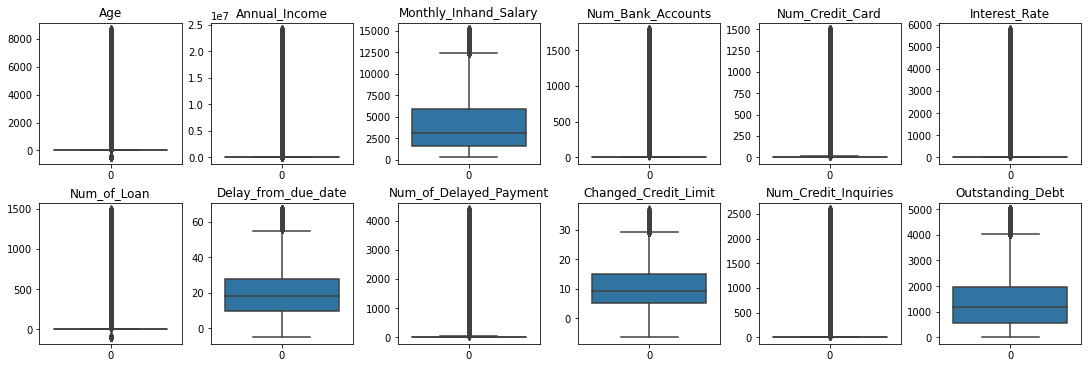

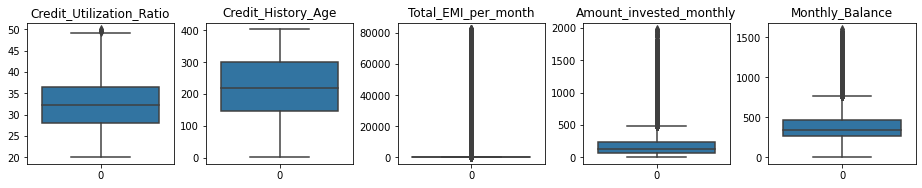

In [ ]:
%matplotlib inline
def box_plot_utility(df):
    fig, axs = plt.subplots(2, 6, figsize=(15, 5), constrained_layout=True)

    for col, ax in zip(num[:12], axs.flatten()):
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
    plt.show()

    fig, axs = plt.subplots(1, 5, figsize=(12.7, 2.5), constrained_layout=True)
    for col, ax in zip(num[12:], axs.flatten()):
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
        
box_plot_utility(df)   

We can see that most features have outliers, but we can show that most data can be quickly restored by substituting the features' mode value for each Customer_ID. 

In [ ]:
from statistics import mode

features_mode = ['Age','Annual_Income', 'Num_Bank_Accounts', 'Occupation',
                 'Num_Credit_Card', 'Num_of_Loan', 'Interest_Rate',
                 'Outstanding_Debt', 'Total_EMI_per_month']

for feature in features_mode:
    tmp = df[['Customer_ID',
               feature]].groupby('Customer_ID')[feature].apply(mode)
    df[feature] = df['Customer_ID'].map(tmp.to_dict())


# Restore back the 'Occupation' values where the algorithm fail
customers_wrong = df.loc[df.Occupation == '', 'Customer_ID'].unique()
for customer in customers_wrong:
    df.loc[df.Customer_ID == customer,
           'Occupation'] = df_old.loc[df_old.Customer_ID == customer,
                                      'Occupation'].unique()[1]


# Restore back the 'Num_Credit_Card' values where the algorithm fail
tmp_num_cc = df_old.loc[df_old['Num_Bank_Accounts'] == -1,
                        'Num_Credit_Card']
tmp_num_cc.loc[55636] = 4
df.loc[tmp_num_cc.index, 'Num_Credit_Card']


# Set to NaN values manually for some outliers because they are considered erroneous.
df.loc[df['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan
df.loc[df['Num_of_Delayed_Payment'] > 30, 'Num_of_Delayed_Payment'] = np.nan


# Drop the unuseful column Customer_ID
df.drop(columns='Customer_ID', inplace=True)

We can see how the 

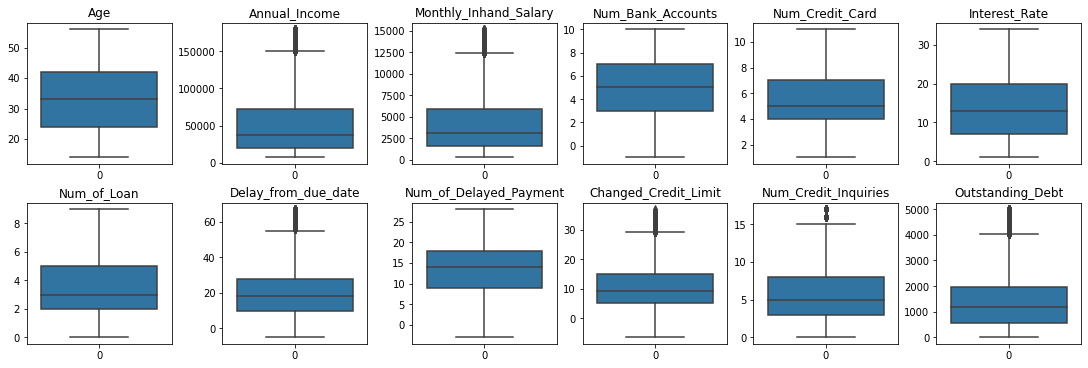

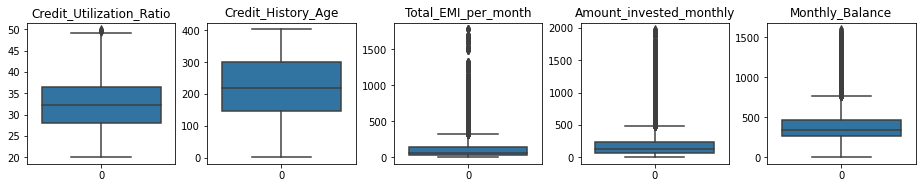

In [ ]:
box_plot_utility(df)   

##  Model and visualization ##

### Splitting up the data ###
The data is split into Training, Validation, and Test sets, with 60%, 20%, and 20% percentages, respectively.

In [56]:
scale_mapper = {"Poor":0, "Standard":1, "Good":2}
df["Credit_Score"] = df["Credit_Score"].replace(scale_mapper)

In [57]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df.drop(columns=["Credit_Score"]),
    df["Credit_Score"],
    test_size= 0.20,
    shuffle=True
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size= 0.25,
    random_state= 42,
    shuffle=True
    )

In [58]:
X_train.shape, X_val.shape, X_test.shape

((60000, 23), (20000, 23), (20000, 23))

### Data preparation ###
#### Imbalanced learning ####
As the data is somewhat imbalanced, RandomOverSampler is used to generate new datapoints of the least represented target values. This allowed us to get the same number of points for each class.

#### Onehot-encoding ####
The categorical features are one hot encoded to features giving "1" or "0" for each possible category. This heavily increases the dimensionality of the data, mostly due to the feature "Type_of_Loan", which has over 6000 categories. This feature has, however, proven to be crucial for the accuracy of the model. This can be explained by the fact that the bank could be interested not only in the type of loan but also in the order in which they are stipulated.

#### Feature scaling ####
To improve the chances of converging during training, the data is scaled by MaxAbsScaler, which scale each feature by its maximum absolute value.

In [59]:
# Oversampling due to imbalance
sampler = RandomOverSampler() 

X_train, y_train = sampler.fit_resample(X_train, y_train)


# Making a pipeline for transforming

cat_preprocessor = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")),
     ("onehot", OneHotEncoder(sparse=True, handle_unknown="ignore"))]
    )

num_preprocessor = Pipeline(
    [("imputer", SimpleImputer(strategy="median"))]
    )  

preprocessor = ColumnTransformer(
    [("categorical", cat_preprocessor, cat), 
    ("numerical", num_preprocessor, num)]
    )

    
# Transforming
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


# Scaling
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train).toarray()
X_val = scaler.transform(X_val).toarray()
X_test = scaler.transform(X_test).toarray()


sorted(Counter(y_train).items())

[(0, 31847), (1, 31847), (2, 31847)]

#### Visualization ####
The test set is used for training a UMAP visualization of the data's clusters. We can see that although the Credit Scores are somewhat intertwined, especially for Credit Scores closer to each other (Standard & Good, Poor & Standard), the algorithm finds clear clusters. It is especially hard for the algorithm to differ Good from other credit scores, as can be seen in the bottom right clusters.

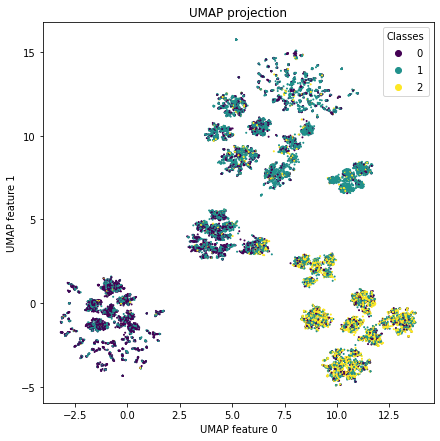

In [60]:
reducer = UMAP.UMAP(15)
embedding = reducer.fit_transform(X_test)

le = LabelEncoder()

plt.figure(figsize=(7, 7))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],  s=1, c=y_test)
plt.xlabel('UMAP feature 0')
plt.ylabel('UMAP feature 1')
plt.title('UMAP projection')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")

plt.show()

### Neural Network with Softmax Function ###
In both softmax regression and neural networks with Softmax outputs, $N$ outputs are generated and one output is selected as the predicted category. In both cases a vector $\mathbf{z}$ is generated by a linear function which is applied to a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will add to 1, so that they can be interpreted as probabilities. The larger inputs  will correspond to larger output probabilities.
<center>  <img  src="../images/C2_W2_SoftmaxReg_NN.png" width="600" /> 

The softmax function can be written:
$$a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }} \tag{1}$$

The output $\mathbf{a}$ is a vector of length N, so for softmax regression, you could also write:
$$
\begin{align}
\mathbf{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}
=
\frac{1}{ \sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix} \tag{2}
\end{align}
$$

Which shows the output is a vector of probabilities. The first entry is the probability the input is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$.

#### Cost ####
The loss function associated with Softmax, the cross-entropy loss, is:
\begin{equation}
  L(\mathbf{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} \tag{3}
\end{equation}

Where y is the target category for this example and $\mathbf{a}$ is the output of a softmax function. In particular, the values in $\mathbf{a}$ are probabilities that sum to one.

Note in (3) above, only the line that corresponds to the target contributes to the loss, other lines are zero. To write the cost equation we need an 'indicator function' that will be 1 when the index matches the target and zero otherwise. 
    $$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{if $y==n$}.\\
    0, & \text{otherwise}.
  \end{cases}$$
Now the cost is:
\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Where $m$ is the number of examples, $N$ is the number of outputs. This is the average of all the losses.


### L2 Regularization ###

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying the cost function as follows:

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \sum_{j=1}^{N} \left[ 1\left\{y^{(i)} == j\right\}\log\left(a_j^{[L](i)}\right)\right] }_\text{SparseCategoricalCrossentropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$


where:
- $\lambda$ is the regularization parameter.

<a name='5'></a>   
#### 5 - Adam ####

Adam is one of the most effective optimization algorithms for training neural networks. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam;
- L is the number of layers;
- $\beta_1 (=0.9)$ and $\beta_2 (=0.999)$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate (to be tuned);
- $\varepsilon (=10^{-8})$ is a very small number to avoid dividing by zero.

In general Adam converges a faster respect mini-batch gradient descent and Momentum.

### Tune the model architecture ###

A Keras Tuner tests different neural networks to find the best hyperparameters. The tuner test all combinations of the following:

* Number of hidden layers: [1, 3],
* Number of neurons per layer: [250, 500],
* Learning rates: [0.01, 0.001],
* A BatchNormalization layer is added before the output layer to reduce overfitting. It normalizes input or output of the activation functions in a hidden layer.
* A Dropout layer with 0.8 as dropout rate is added before the output layer in order to reduce overfitting.

Dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration. At each iteration, you train a different model that uses only a subset of your neurons. Neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time.$\\$

The Rectified Linear Unit (ReLU) activation function $ a(z) = max(0, z) $ is chosen because we have an output always positive. In general, it is the recommended activation function for hidden layers.$\\$

First it is applied the L2 regularization, then it is removed. 

In [ ]:
# He initialization for W and b and it recommended for layers with a ReLU activation
initializer = initializers.HeNormal()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

def build_model(hp):
    model = Sequential(name='Credit_Score_classification')
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            Dense(
                units=hp.Int('units_' + str(i), min_value=250, max_value=500,  step=250), 
                activation='relu',
                kernel_regularizer=L2(3e-3),
                name=f'L{i}'
                )
            )
        
    model.add(BatchNormalization())
    model.add(Dropout(0.8, seed=123))
        
    model.add(
        Dense(3, kernel_initializer=initializer, activation='linear', name=f'L{i+1}'),
        
        )
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lrate', values=[1e-2, 1e-3])),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )
    
    return model

The Random Search is a variation of the Grid Search algorithm, which randomly samples the search space instead of discretizing it with a Cartesian grid. The algorithm has no end. Instead a time budget has to be specified (i.e. a number of trials). This algorithm suffers likewise from the curse of dimensionality to reach a preset fixed sampling density. One of the advantages of random search is that if two hyper-parameters are little correlated, random search enables to find more precisely the optima of each parameter.
<center>
<img src="../images/Random vs Grid.jpeg" style="width:720px;height:350px;">

In [ ]:
import keras_tuner as kt

# RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=50,
    directory='keras_tuner',
    project_name="Credit_Score_classification",
    overwrite=True
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[callback]
    )

Trial 34 Complete [00h 01m 14s]
val_accuracy: 0.6700000166893005

Best val_accuracy So Far: 0.7350999712944031
Total elapsed time: 00h 50m 34s


In [ ]:
model = tuner.get_best_models()[0]

In [ ]:
model.summary()

Model: "Credit_Score_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0 (Dense)                   (None, 500)               1893000   
_________________________________________________________________
L1 (Dense)                   (None, 250)               125250    
_________________________________________________________________
L2 (Dense)                   (None, 250)               62750     
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
L3 (Dense)                   (None, 3)                 753       
Total params: 2,082,753
Trainable params: 2,082,253
Non-trainable params: 500
___________________________

In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner/Credit_Score_classification
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 500
lrate: 0.001
units_1: 250
units_2: 250
Score: 0.7350999712944031
Trial summary
Hyperparameters:
num_layers: 2
units_0: 250
lrate: 0.001
units_1: 500
units_2: 500
Score: 0.733299970626831
Trial summary
Hyperparameters:
num_layers: 3
units_0: 500
lrate: 0.001
units_1: 500
units_2: 500
Score: 0.7325999736785889
Trial summary
Hyperparameters:
num_layers: 3
units_0: 250
lrate: 0.001
units_1: 250
units_2: 250
Score: 0.7320500016212463
Trial summary
Hyperparameters:
num_layers: 2
units_0: 250
lrate: 0.001
units_1: 250
units_2: 500
Score: 0.7294999957084656
Trial summary
Hyperparameters:
num_layers: 3
units_0: 500
lrate: 0.001
units_1: 500
units_2: 250
Score: 0.7292500138282776
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
lrate: 0.001
units_1: 500
units_2: 500
Score: 0.7290499806404114
Trial summary
Hyperparameters:
num_layers: 3
units

In [ ]:
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [ ]:
X_train.shape, y_train.shape

((116201, 3785), (116201,))

In [ ]:
logits = model(X_train)
f_X = tf.nn.softmax(logits)
y_pred_train = np.argmax(f_X, axis=1)


print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     37988
           1       0.79      0.67      0.73     42628
           2       0.75      0.91      0.82     35585

    accuracy                           0.79    116201
   macro avg       0.79      0.80      0.79    116201
weighted avg       0.79      0.79      0.79    116201



In [ ]:
logits = model(X_test)
f_X = tf.nn.softmax(logits)
y_pred_test = np.argmax(f_X, axis=1)


print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5808
           1       0.85      0.66      0.74     10546
           2       0.55      0.87      0.67      3646

    accuracy                           0.73     20000
   macro avg       0.72      0.77      0.73     20000
weighted avg       0.77      0.73      0.74     20000



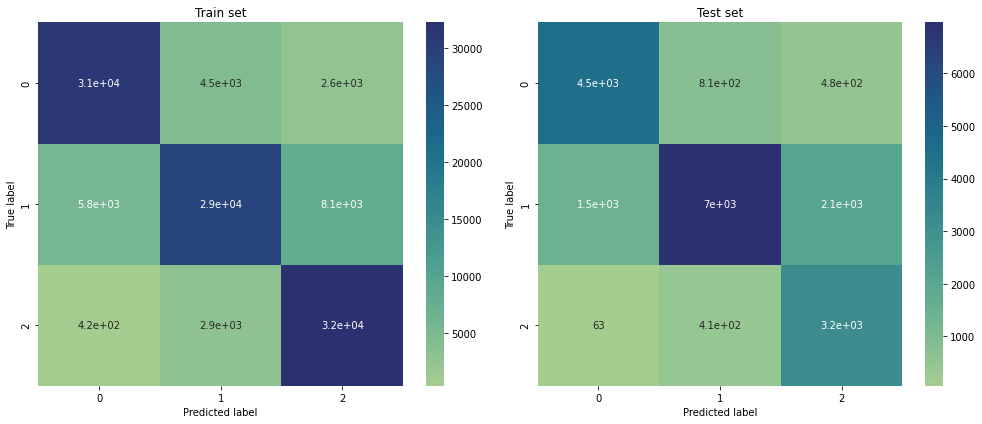

In [ ]:
def conf_matrix_train_test(y_train, y_pred_train, y_test, y_pred_test):
    cm = confusion_matrix(y_train, y_pred_train)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm,ax=axs[0], cmap="crest", annot=True)
    axs[0].set_title('Train set')
    axs[0].set_ylabel('True label')
    axs[0].set_xlabel('Predicted label')

    cm = confusion_matrix(y_test, y_pred_test)

    sns.heatmap(cm,ax=axs[1], cmap="crest", annot=True)
    axs[1].set_title('Test set')
    axs[1].set_ylabel('True label')
    axs[1].set_xlabel('Predicted label')
    fig.tight_layout()

    
conf_matrix_train_test(y_train, y_pred_train, y_test, y_pred_test)

In [ ]:
initializer = initializers.HeNormal()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


def build_model(hp):
    model = Sequential(name='Credit_Score_classification')
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            Dense(
                units=hp.Int('units_' + str(i), min_value=250, max_value=500,  step=250), 
                activation='relu',
                name=f'L{i}'
                )
            )
        
    model.add(BatchNormalization())
    model.add(Dropout(0.8, seed=123))
        
    model.add(
        Dense(3, kernel_initializer=initializer, activation='linear', name=f'L{i+1}'),
        
        )
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lrate', values=[1e-2, 1e-3])),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
        )
    
    return model

In [ ]:
import keras_tuner as kt

# RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=50,
    directory='keras_tuner',
    project_name="Credit_Score_classification",
    overwrite=True
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[callback]
    )

Trial 38 Complete [00h 01m 18s]
val_accuracy: 0.7667499780654907

Best val_accuracy So Far: 0.7720500230789185
Total elapsed time: 00h 54m 23s


In [ ]:
model = tuner.get_best_models()[0]

In [ ]:
model.summary()

Model: "Credit_Score_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0 (Dense)                   (None, 250)               946000    
_________________________________________________________________
L1 (Dense)                   (None, 250)               62750     
_________________________________________________________________
batch_normalization (BatchNo (None, 250)               1000      
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
L2 (Dense)                   (None, 3)                 753       
Total params: 1,010,503
Trainable params: 1,010,003
Non-trainable params: 500
_________________________________________________________________


In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner/Credit_Score_classification
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 250
lrate: 0.01
units_1: 250
units_2: 500
Score: 0.7720500230789185
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
lrate: 0.01
units_1: 250
units_2: 250
Score: 0.7720000147819519
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
lrate: 0.01
units_1: 500
units_2: 250
Score: 0.7709000110626221
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
lrate: 0.001
units_1: 500
units_2: 250
Score: 0.7706000208854675
Trial summary
Hyperparameters:
num_layers: 2
units_0: 250
lrate: 0.01
units_1: 500
units_2: 250
Score: 0.7705000042915344
Trial summary
Hyperparameters:
num_layers: 2
units_0: 500
lrate: 0.001
units_1: 250
units_2: 250
Score: 0.7692000269889832
Trial summary
Hyperparameters:
num_layers: 2
units_0: 250
lrate: 0.001
units_1: 500
units_2: 250
Score: 0.7691500186920166
Trial summary
Hyperparameters:
num_layers: 3
units_0:

In [ ]:
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [ ]:
X_train.shape, y_train.shape

((115859, 3783), (115859,))

In [ ]:
logits = model(X_train)
f_X = tf.nn.softmax(logits)
y_pred_train = np.argmax(f_X, axis=1)


print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     37689
           1       0.83      0.80      0.81     42609
           2       0.85      0.91      0.88     35561

    accuracy                           0.86    115859
   macro avg       0.86      0.86      0.86    115859
weighted avg       0.86      0.86      0.86    115859



In [ ]:
logits = model(X_test)
f_X = tf.nn.softmax(logits)
y_pred_test = np.argmax(f_X, axis=1)


print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      5819
           1       0.83      0.75      0.79     10565
           2       0.65      0.82      0.73      3616

    accuracy                           0.77     20000
   macro avg       0.75      0.78      0.76     20000
weighted avg       0.78      0.77      0.77     20000



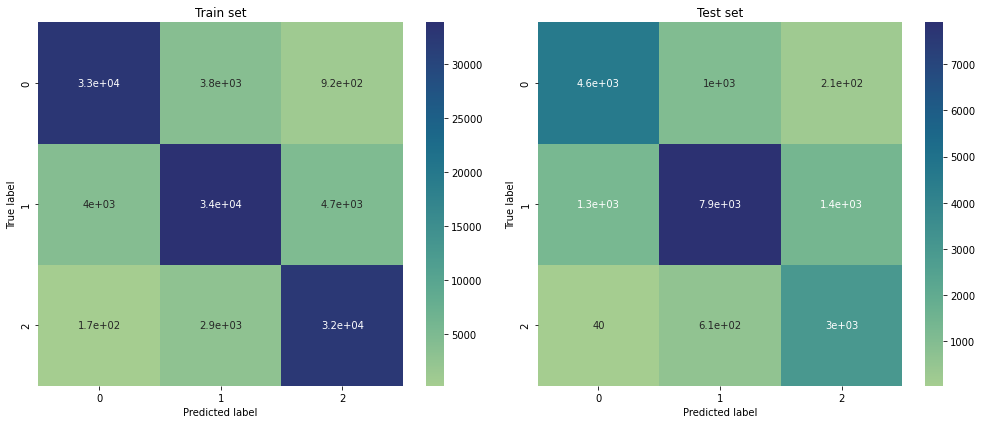

In [ ]:
conf_matrix_train_test(y_train, y_pred_train, y_test, y_pred_test)

# **Introduction to Support Vector Machines**

**Support Vector Machines** (SVMs in short) are machine learning algorithms that are used for classification and regression purposes. SVMs are one of the powerful machine learning algorithms for classification, regression and outlier detection purposes. An SVM classifier builds a model that assigns new data points to one of the given categories. Thus, it can be viewed as a non-probabilistic binary linear classifier.

The original SVM algorithm was developed by Vladimir N Vapnik and Alexey Ya. Chervonenkis in 1963. At that time, the algorithm was in early stages. The only possibility is to draw hyperplanes for linear classifier. In 1992, Bernhard E. Boser, Isabelle M Guyon and Vladimir N Vapnik suggested a way to create non-linear classifiers by applying a kernel function to maximum-margin hyperplanes. The current standard was proposed by Corinna Cortes and Vapnik in 1993 and published in 1995.

SVMs can be used for linear classification purposes. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using a **kernel**. It enable us to implicitly map the inputs into high dimensional feature spaces.

## Support Vector Machines intuition

### Hyperplane

A hyperplane is a decision boundary which separates between given set of data points having different class labels. The SVM classifier separates data points using a hyperplane with the maximum amount of margin. This hyperplane is known as the `maximum margin hyperplane` and the linear classifier it defines is known as the `maximum margin classifier`.


### Support Vectors

Support vectors are the sample data points, which are closest to the hyperplane.  These data points will define the separating line or hyperplane better by calculating margins.


### Margin

A margin is a separation gap between the two lines on the closest data points. It is calculated as the perpendicular distance from the line to support vectors or closest data points. In SVMs, we try to maximize this separation gap so that we get maximum margin.

The following diagram illustrates these concepts visually.


### Margin in SVM

<p align='center'>
<img src='https://static.wixstatic.com/media/8f929f_7ecacdcf69d2450087cb4a898ef90837~mv2.png'>
</p>

### SVM Under the hood

In SVMs, our main objective is to select a hyperplane with the maximum possible margin between support vectors in the given dataset. SVM searches for the maximum margin hyperplane in the following 2 step process –


1.	Generate hyperplanes which segregates the classes in the best possible way. There are many hyperplanes that might classify the data. We should look for the best hyperplane that represents the largest separation, or margin, between the two classes.

2.	So, we choose the hyperplane so that distance from it to the support vectors on each side is maximized. If such a hyperplane exists, it is known as the **maximum margin hyperplane** and the linear classifier it defines is known as a **maximum margin classifier**. 


The following diagram illustrates the concept of **maximum margin** and **maximum margin hyperplane** in a clear manner.


### Maximum margin hyperplane
<p align='center'><img src='https://static.packt-cdn.com/products/9781783555130/graphics/3547_03_07.jpg'></p>

### Problem with dispersed datasets

Sometimes, the sample data points are so dispersed that it is not possible to separate them using a linear hyperplane. 
In such a situation, SVMs uses a `kernel trick` to transform the input space to a higher dimensional space as shown in the diagram below. It uses a mapping function to transform the 2-D input space into the 3-D input space. Now, we can easily segregate the data points using linear separation.


### Kernel trick - transformation of input space to higher dimensional space
<p align='center'><img src='http://www.aionlinecourse.com/uploads/tutorials/2019/07/11_21_kernel_svm_3.png'></p>



### **Linear kernel**

In linear kernel, the kernel function takes the form of a linear function as follows-

**linear kernel : K($x_i$ , $x_j$) = $x_i^T$ $x_j$**

Linear kernel is used when the data is linearly separable. It means that data can be separated using a single line. It is one of the most common kernels to be used. It is mostly used when there are large number of features in a dataset. Linear kernel is often used for text classification purposes.

Training with a linear kernel is usually faster, because we only need to optimize the C regularization parameter. When training with other kernels, we also need to optimize the γ parameter. So, performing a grid search will usually take more time.

Linear kernel can be visualized with the following figure
<p align="center">
<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_svm_kernels_thumb.png'>
</p>

### **Polynomial Kernel**

Polynomial kernel represents the similarity of vectors (training samples) in a feature space over polynomials of the original variables. The polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of the input samples.

For degree-d polynomials, the polynomial kernel is defined as follows –

**Polynomial kernel : $K(x_i , x_j) = (\gamma x_i^T x_j + r)^d , \gamma > 0$**

Polynomial kernel is very popular in Natural Language Processing. The most common degree is d = 2 (quadratic), since larger degrees tend to overfit on NLP problems. It can be visualized with the following diagram.

<p align='center'><img src='https://www.researchgate.net/profile/Cheng_Soon_Ong/publication/23442384/figure/fig12/AS:341444054274063@1458418014823/The-effect-of-the-degree-of-a-polynomial-kernel-The-polynomial-kernel-of-degree-1-leads.png'></p>

### **Radial Basis Function Kernel**

Radial basis function kernel is a general purpose kernel. It is used when we have no prior knowledge about the data. The RBF kernel on two samples x and y is defined by the following equation 
$$K(x, y) = \exp\left ( -\frac{\left\|x-y \right\|^2}{2\sigma^2} \right ) $$

### **Sigmoid kernel**

Sigmoid kernel has its origin in neural networks. We can use it as the proxy for neural networks. Sigmoid kernel is given by the following equation $$K(x, y) = \tanh \left ( \alpha x^Ty + c \right )$$

In [ ]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train, y_train)

SVC()

In [ ]:
print(classification_report(model.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79     42273
           1       0.60      0.75      0.67     34394
           2       0.86      0.72      0.78     51022

    accuracy                           0.75    127689
   macro avg       0.75      0.75      0.75    127689
weighted avg       0.77      0.75      0.75    127689



In [ ]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      6637
           1       0.59      0.86      0.70      7345
           2       0.84      0.50      0.63      6018

    accuracy                           0.69     20000
   macro avg       0.73      0.68      0.68     20000
weighted avg       0.73      0.69      0.68     20000



It is prohibitive to use SVM for this particular dataset, because the SVM training time is $O(n^3)$, as shown in the figure below:

<center>
<img src="../images/SVC_time.png" style="width:331px;height:209px;">

# XGBoost

## Decision Tree algorithm terminology <a class="anchor" id="3"></a>

Before we dive into how a decision tree worksExternal link:open_in_new, let’s define some key terms of a decision tree.
- Root node: The base of the decision tree.
- Splitting: The process of dividing a node into multiple sub-nodes.
- Decision node: When a sub-node is further split into additional sub-nodes.
- Leaf node: When a sub-node does not further split into additional sub-nodes; represents possible outcomes.
- Pruning: The process of removing sub-nodes of a decision tree.
- Branch: A subsection of the decision tree consisting of multiple nodes.

Let’s take a look at an example for this. You’re a golfer, and a consistent one at that. On any given day you want to predict where your score will be in two buckets: below par or over par.

<p align='center'><img src='https://www.mastersindatascience.org/wp-content/uploads/sites/54/2022/05/tree-graphic.jpg'></p>

While you are a consistent golfer, your score is dependent on a few sets of input variables. Wind speed, cloud cover and temperature all play a role. In addition, your score tends to deviate depending on whether or not you walk or ride a cart. And it deviates if you are golfing with friends or strangers.

A method to reduce the overfitting is training several decision trees independently, it isn't supposed to learn all the trees at once. But it is highly used the addition strategy: fix what we have learned, and add one new tree at a time.
So the prediction will be: 
$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

And the tree used for the next step, is the one who optimizes the following objective function: 
$$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \omega(f_t)$$

Where $g_i$, $h_i$, and the regularization term $\omega(f)$ are defined as: 
$$\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})\\
\omega(f) &= \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\end{split}$$

Where $w$ is the vector scores on the leaves and T is the number of leaves.
This becomes our optimization goal for the new tree. The important advantages of this definition is that the value of the objective function only depends on $g_i$ and $h_i$, and we can choose any loss function we want.

In general, the best objective reduction we can obtain is given by
$$
\begin{split} w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T \quad(1)\end{split}
$$
Where $G_j = \sum_{i\in I_j} g_i$ and $H_j = \sum_{i\in I_j} h_i$ ($I_j = \{i|q(x_i)=j\}$ is the set of indices of data points assigned to the $j$-th leaf).

## Building the Trees
The equation 1 measures how good a tree is, and we would like to do this for all the trees we have. Realistically it is intractable, so the optimization are made every level at a time. Every node is splitted using the following formula: 
$$
Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma
$$

The first addend represents the score on the new left leaf, the second represents the score on the new right leaf, the third represents the original leaf score, and the last is regularization on the additional leaf. 

Analysing the previous formula, it shows that if the gain is smaller than $\gamma$, it is better not to add that branch. (**Pruning Method**)

### Model Results

In [ ]:
model = xgb.XGBClassifier(tree_method='gpu_hist')
            
model.fit(X=X_train, y=y_train, eval_set=[(X_train, y_train), (X_val,y_val)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

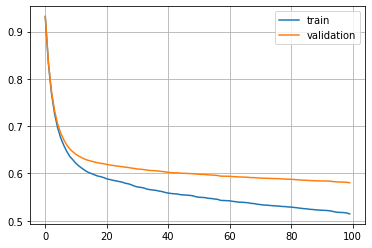

In [ ]:
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='validation')
# show the legend
plt.legend()
plt.grid()

In [ ]:
y_hat = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

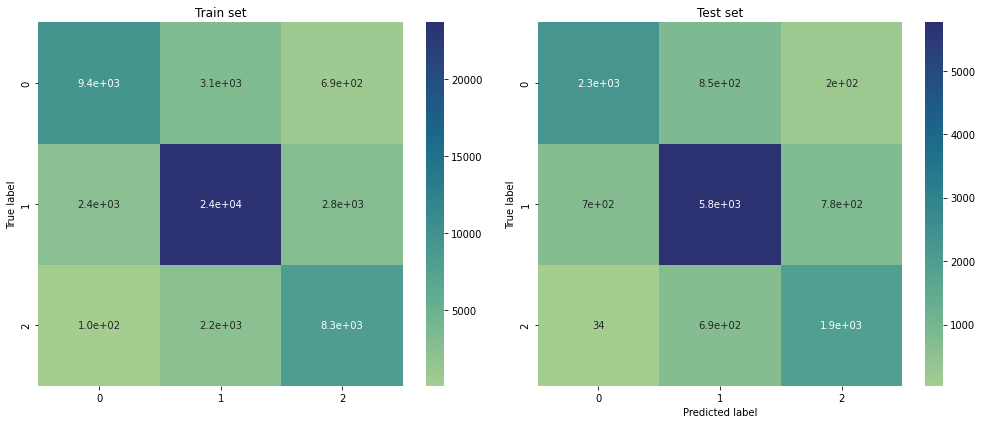

In [ ]:
cm = confusion_matrix(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val]))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm,ax=axs[0], cmap="crest", annot=True)
axs[0].set_title('Train set')
axs[0].set_ylabel('True label')

cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm,ax=axs[1], cmap="crest", annot=True)
axs[1].set_title('Test set')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')
fig.tight_layout()

In [ ]:
print("Report Train Set:\n")
print(classification_report(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val])))
print("Report Test Set:\n")
print(classification_report(y_pred_test, y_test))

Report Train Set:

              precision    recall  f1-score   support

           0       0.79      0.71      0.75     13248
           1       0.82      0.82      0.82     28879
           2       0.71      0.78      0.74     10628

    accuracy                           0.79     52755
   macro avg       0.77      0.77      0.77     52755
weighted avg       0.79      0.79      0.79     52755

Report Test Set:

              precision    recall  f1-score   support

           0       0.68      0.75      0.72      2983
           1       0.80      0.79      0.79      7302
           2       0.73      0.66      0.69      2904

    accuracy                           0.75     13189
   macro avg       0.74      0.74      0.73     13189
weighted avg       0.76      0.75      0.75     13189



### Parameter Tuning

In [ ]:
param_tuning = {
        'learning_rate': [0.1, 0.06, 0.01, 0.006, 0.001],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [200],
        'objective': ['multi:softmax'], 
        'reg_alpha'   : [0.5, 0.2, 1],
        'reg_lambda'  : [2, 3, 5]
    }

xgb_model = xgb.XGBClassifier(tree_method='gpu_hist')

rsearch = RandomizedSearchCV(estimator = xgb_model,
                             param_distributions = param_tuning,
                             cv = 2,
                             n_jobs = 1,
                             verbose = 0)

rsearch.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:1.09342	validation_1-mlogloss:1.09346
[1]	validation_0-mlogloss:1.08782	validation_1-mlogloss:1.08787
[2]	validation_0-mlogloss:1.08298	validation_1-mlogloss:1.08300
[3]	validation_0-mlogloss:1.07738	validation_1-mlogloss:1.07738
[4]	validation_0-mlogloss:1.07244	validation_1-mlogloss:1.07244
[5]	validation_0-mlogloss:1.06755	validation_1-mlogloss:1.06756
[6]	validation_0-mlogloss:1.06245	validation_1-mlogloss:1.06243
[7]	validation_0-mlogloss:1.05734	validation_1-mlogloss:1.05731
[8]	validation_0-mlogloss:1.05239	validation_1-mlogloss:1.05234
[9]	validation_0-mlogloss:1.04787	validation_1-mlogloss:1.04783
[10]	validation_0-mlogloss:1.04286	validation_1-mlogloss:1.04280
[11]	validation_0-mlogloss:1.03818	validation_1-mlogloss:1.03811
[12]	validation_0-mlogloss:1.03376	validation_1-mlogloss:1.03369
[13]	validation_0-mlogloss:1.02921	validation_1-mlogloss:1.02916
[14]	validation_0-mlogloss:1.02460	validation_1-mlogloss:1.02454
[15]	validation_0-mlogloss:1.02017	

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           num_parallel_tree=None,
                                           predictor=None, random_state

In [ ]:
print('Best Score: %s' % rsearch.best_score_)
print('Best Hyperparameters: %s' % rsearch.best_params_)

Best Score: 0.7711418895010869
Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 5, 'reg_alpha': 0.5, 'objective': 'multi:softmax', 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [ ]:
y_hat = rsearch.predict(X_train)
y_pred_val = rsearch.predict(X_val)
y_pred_test = rsearch.predict(X_test)

In [ ]:
print("Report Train Set:\n")
print(classification_report(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val])))
print("Report Test Set:\n")
print(classification_report(y_pred_test, y_test))

Report Train Set:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     13253
           1       0.92      0.92      0.92     28855
           2       0.91      0.90      0.90     10647

    accuracy                           0.92     52755
   macro avg       0.91      0.91      0.91     52755
weighted avg       0.92      0.92      0.92     52755

Report Test Set:

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      3181
           1       0.83      0.82      0.83      7359
           2       0.76      0.75      0.75      2649

    accuracy                           0.80     13189
   macro avg       0.79      0.79      0.79     13189
weighted avg       0.80      0.80      0.80     13189



In [ ]:
params = {'subsample': 0.7,
 'reg_lambda': 3,
 'reg_alpha': 1,
 'objective': 'multi:softmax',
 'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.006,
 'colsample_bytree': 0.7}

#params = results_RS['params'][5] #7, 3

model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.006, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=1, ...)

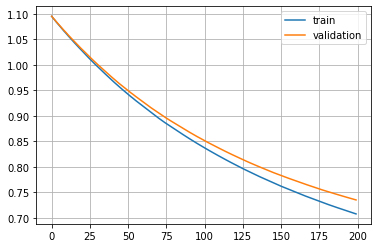

In [ ]:
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='validation')
# show the legend
plt.legend()
plt.grid()

In [ ]:
y_hat = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

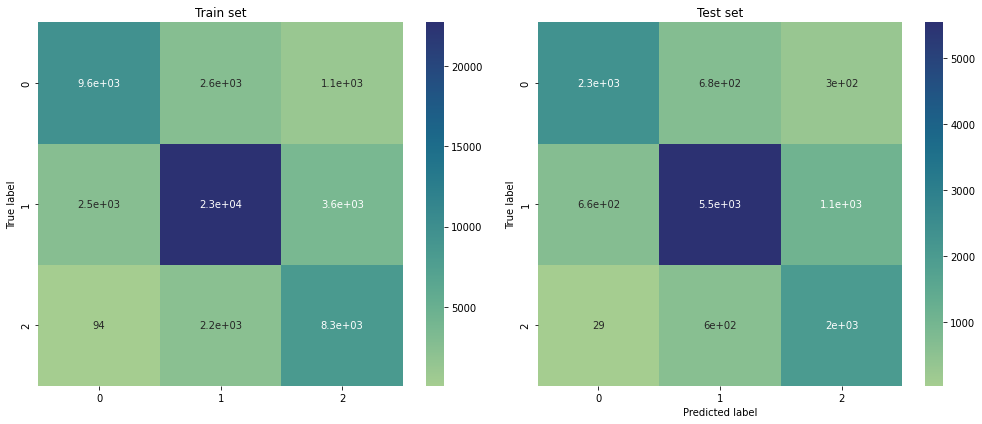

In [ ]:
cm = confusion_matrix(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val]))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm,ax=axs[0], cmap="crest", annot=True)
axs[0].set_title('Train set')
axs[0].set_ylabel('True label')

cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm,ax=axs[1], cmap="crest", annot=True)
axs[1].set_title('Test set')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')
fig.tight_layout()

In [ ]:
print("Report Train Set:\n")
print(classification_report(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val])))
print("Report Test Set:\n")
print(classification_report(y_pred_test, y_test))

Report Train Set:

              precision    recall  f1-score   support

           0       0.79      0.72      0.75     13253
           1       0.83      0.79      0.81     28855
           2       0.64      0.78      0.70     10647

    accuracy                           0.77     52755
   macro avg       0.75      0.76      0.75     52755
weighted avg       0.78      0.77      0.77     52755

Report Test Set:

              precision    recall  f1-score   support

           0       0.70      0.77      0.74      3000
           1       0.76      0.81      0.79      6822
           2       0.76      0.59      0.67      3367

    accuracy                           0.75     13189
   macro avg       0.74      0.73      0.73     13189
weighted avg       0.75      0.75      0.74     13189



In [ ]:
params = {'subsample': 0.7,
 'reg_lambda': 3,
 'reg_alpha': 1,
 'objective': 'multi:softmax',
 'n_estimators': 400,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.006,
 'colsample_bytree': 0.7}

#params = results_RS['params'][5] #7, 3

model = xgb.XGBClassifier(tree_method='gpu_hist', **params)
model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.006, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=1, ...)

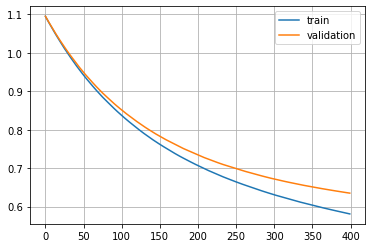

In [ ]:
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='validation')
# show the legend
plt.legend()
plt.grid()

In [ ]:
y_hat = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

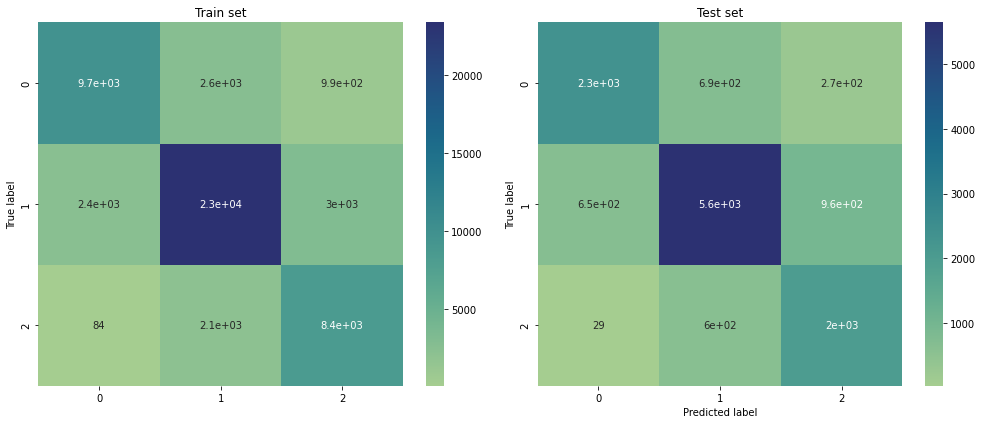

In [ ]:
cm = confusion_matrix(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val]))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm,ax=axs[0], cmap="crest", annot=True)
axs[0].set_title('Train set')
axs[0].set_ylabel('True label')

cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm,ax=axs[1], cmap="crest", annot=True)
axs[1].set_title('Test set')
axs[1].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')
fig.tight_layout()

In [ ]:
print("Report Train Set:\n")
print(classification_report(np.concatenate([y_train, y_val]), np.concatenate([y_hat, y_pred_val])))
print("Report Test Set:\n")
print(classification_report(y_pred_test, y_test))

Report Train Set:

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     13253
           1       0.83      0.81      0.82     28855
           2       0.68      0.79      0.73     10647

    accuracy                           0.79     52755
   macro avg       0.77      0.78      0.77     52755
weighted avg       0.79      0.79      0.79     52755

Report Test Set:

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3020
           1       0.78      0.81      0.80      6942
           2       0.76      0.62      0.68      3227

    accuracy                           0.76     13189
   macro avg       0.75      0.74      0.74     13189
weighted avg       0.76      0.76      0.76     13189



# Conclusions
The models used to perform the predictions reaches good performances after tuning the parameters. The models which show the best results are the Neural Network and the XGBoost. All the models have overfitting issues of different magnitudes. The Neural Network models have the most overfitting problems, but they still perform slightly better than the others. On the other hand, we can't tune parameters on the SVM due to the computational time, but it still has decent results. In literature, the best model has an accuracy of 79%. As we show in the umap representation, the classes overlap, making the classification process more difficult.
In conclusion, we can say that the best model is the one that better generalizes the data, and the XGBoost satisfies this condition.

**Here are summarized the results of our four models**: 

<table> 
    <tr>
        <td>
        <b>model</b>
        </td>
        <td>
        <b>train accuracy</b>
        </td>
        <td>
        <b>test accuracy</b>
        </td>
    </tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        86%
        </td>
        <td>
        77%
        </td>
    <tr>
        <td>
        4-layer NN with L2 + dropout
        </td>
        <td>
        79%
        </td>
        <td>
        73%
        </td>
    </tr>
    <tr>
        <td>
        SVM
        </td>
        <td>
        75%
        </td>
        <td>
        69%
        </td>
    </tr>
    <tr>
        <td>
        XGBoost
        </td>
        <td>
        79%
        </td>
        <td>
        76%
        </td>
    </tr>         
</table> 